# Lecture 3a

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import xlrd

In [3]:
# These functions are to visulize graph inline
from IPython.display import clear_output, Image, display, HTML
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [3]:
# Data
DATA_FILE = 'E:/Semester 3/Coursera/CS20SI/data/fire_theft.xls'

# Step 1: Read in data
book = xlrd.open_workbook(DATA_FILE,encoding_override='utf_8')
sheet = book.sheet_by_index(0)
data = np.asarray([sheet.row_values(i) for i in 
                   range(1,sheet.nrows)])
n_samples = sheet.nrows -1 

## Linear Regression

In [4]:
# Prdict Y from X via learning from given data (X,Y)
#Phase 1: Assemble Graph

tf.reset_default_graph()
# Step 2: create placeholder for input X and Y
X = tf.placeholder(tf.float32,name='X')
Y = tf.placeholder(tf.float32,name='Y')

#Step 3: Weights and bias
w = tf.Variable(0.0,name='weights')
b = tf.Variable(0.0, name='bias')

# Step 4: Build model 
Y_predicted = X*w + b

# Step 5: Loss
loss = tf.square(Y-Y_predicted,name='loss')

#Step 6: Optimizer Gradient Descent 
optimizer = tf.train.GradientDescentOptimizer(
    learning_rate=0.001).minimize(loss)


In [5]:
#Step Session 
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter('/graphs/Lecture3_linear_reg'
                                   ,sess.graph)
    #Step 8: Train Model
    for i in range(100):
        total_loss=0
        for x,y in data: 
            # Session runs train_op and fetch values of loss
            _,l = sess.run([optimizer,loss],
                           feed_dict={X:x,Y:y})
            total_loss +=l
        print('Epoch{0}:{1}'.format(i,total_loss/n_samples))
    writer.close()    
    w_value,b_value = sess.run([w,b])



Epoch0:2069.6319333978354
Epoch1:2117.0123581953535
Epoch2:2092.302723001866
Epoch3:2068.5080461938464
Epoch4:2045.591184088162
Epoch5:2023.5146448101316
Epoch6:2002.2447619835536
Epoch7:1981.748338803649
Epoch8:1961.9944411260742
Epoch9:1942.9520116143283
Epoch10:1924.5930823644712
Epoch11:1906.8898800636332
Epoch12:1889.8164505837929
Epoch13:1873.347133841543
Epoch14:1857.4588400604468
Epoch15:1842.1278742424079
Epoch16:1827.332495119955
Epoch17:1813.0520579712022
Epoch18:1799.2660847636982
Epoch19:1785.9562132299961
Epoch20:1773.1024853109072
Epoch21:1760.689129482884
Epoch22:1748.6984157081515
Epoch23:1737.1138680398553
Epoch24:1725.920873066732
Epoch25:1715.1046249579008
Epoch26:1704.6500954309377
Epoch27:1694.5447134910141
Epoch28:1684.7746311347667
Epoch29:1675.328450968245
Epoch30:1666.1935385839038
Epoch31:1657.3584002084322
Epoch32:1648.8122658529207
Epoch33:1640.5440742547091
Epoch34:1632.5446836102221
Epoch35:1624.8043315147183
Epoch36:1617.3126799958602
Epoch37:1610.062253

In [4]:
show_graph(tf.get_default_graph().as_graph_def())

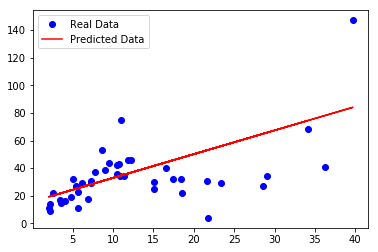

In [7]:
#pLot results
X_np,Y_np = data.T[0],data.T[1]
plt.plot(X_np,Y_np,'bo',label = 'Real Data')
plt.plot(X_np,X_np*w_value+b_value,'r',label='Predicted Data')
plt.legend()
plt.show()

# Linear Regression with Customized Loss Function

### Huber Loss 

In [8]:
# Use Huber Loss instead as it is roboust
# But we can't write conditions in tesnroflow optimizer
def Huber_loss(labels,predictions,delta=0.1):
    residual = tf.abs(predictions-labels)
    condition = tf.less(residual,delta)
    small_res = 0.5 * tf.square(delta)
    large_res = delta * residual - 0.5*tf.square(delta) 
    return tf.where(condition,small_res,large_res)


In [9]:
tf.reset_default_graph()
# Step 2: create placeholder for input X and Y
X = tf.placeholder(tf.float32,name='X')
Y = tf.placeholder(tf.float32,name='Y')

#Step 3: Weights and bias
w = tf.Variable(0.0,name='weights')
b = tf.Variable(0.0, name='bias')

# Step 4: Build model 
Y_predicted = X*w + b


loss_huber = Huber_loss(Y,Y_predicted)
optimizer_huber = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss_huber)

In [10]:
#Step Session 
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter('/graphs/Lecture3_linear_reg'
                                   ,sess.graph)
    #Step 8: Train Model
    for i in range(100):
        total_loss=0
        for x,y in data: 
            # Session runs train_op and fetch values of loss
            _,l = sess.run([optimizer_huber,loss_huber],
                           feed_dict={X:x,Y:y})
            total_loss +=l
        print('Epoch{0}:{1}'.format(i,total_loss/n_samples))
    writer.close()    
    w_value,b_value = sess.run([w,b])

Epoch0:3.328890554252125
Epoch1:3.2608048947794095
Epoch2:3.192719233532747
Epoch3:3.1275756508111954
Epoch4:3.0701447015716914
Epoch5:3.012713640573479
Epoch6:2.9552825270664123
Epoch7:2.897851437330246
Epoch8:2.8404203071480705
Epoch9:2.7829892223789576
Epoch10:2.7255582255976543
Epoch11:2.668127254361198
Epoch12:2.6106963015737987
Epoch13:2.553265306211653
Epoch14:2.4958343349751972
Epoch15:2.4384033722536906
Epoch16:2.3809723995980763
Epoch17:2.323541455325626
Epoch18:2.2661104395630813
Epoch19:2.2152137394462312
Epoch20:2.170374059606166
Epoch21:2.1255342804250263
Epoch22:2.080694506388335
Epoch23:2.0402851525605437
Epoch24:2.0107697308218726
Epoch25:1.9905038884441768
Epoch26:1.9735777643287467
Epoch27:1.959116554020771
Epoch28:1.9475767037698202
Epoch29:1.9360368276635807
Epoch30:1.9244969465902872
Epoch31:1.912957065516994
Epoch32:1.9014171663494337
Epoch33:1.889877305499145
Epoch34:1.8783374221197195
Epoch35:1.8671963152231736
Epoch36:1.8587426794692874
Epoch37:1.8512726204381

In [11]:
show_graph(tf.get_default_graph().as_graph_def())

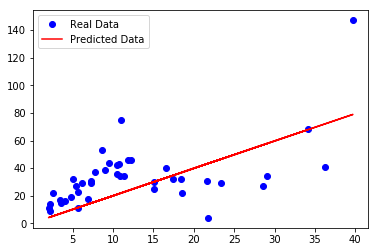

In [12]:
#pLot results
X_np,Y_np = data.T[0],data.T[1]
plt.plot(X_np,Y_np,'bo',label = 'Real Data')
plt.plot(X_np,X_np*w_value+b_value,'r',label='Predicted Data')
plt.legend()
plt.show()

# Qudratic Regression

In [40]:
tf.reset_default_graph()
# Step 2: create placeholder for input X and Y
X = tf.placeholder(tf.float32,name='X')
Y = tf.placeholder(tf.float32,name='Y')

#Step 3: Weights and bias
w = tf.Variable(0.01,name='weight1')
u = tf.Variable(0.01,name='weight2')
b = tf.Variable(0.0, name='bias')

# Step 4: Build model 
Y_predicted = X*X*u + X*w + b

# Step 5: Loss
loss = tf.abs(Y-Y_predicted,name='loss')

#Step 6: Optimizer Gradient Descent 
optimizer_Q = tf.train.GradientDescentOptimizer(
    learning_rate=0.1).minimize(loss)



In [41]:
#Step Session 
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter('/graphs/Lecture3_linear_reg'
                                   ,sess.graph)
    #Step 8: Train Model
    for i in range(100):
        total_loss=0.0001
        for x,y in data: 
            # Session runs train_op and fetch values of loss
            _,l = sess.run([optimizer_Q,loss],
                           feed_dict={X:x,Y:y})
            total_loss +=l
        print('Epoch{0}:{1}'.format(i,total_loss/n_samples))
    writer.close()    
    u_value,w_value,b_value = sess.run([u,w,b])



Epoch0:9940.278363746862
Epoch1:9936.432004675584
Epoch2:9947.40192823995
Epoch3:9937.95359695202
Epoch4:9947.40192823995
Epoch5:9937.95359695202
Epoch6:9947.40192823995
Epoch7:9937.95359695202
Epoch8:9947.40192823995
Epoch9:9937.95359695202
Epoch10:9947.40192823995
Epoch11:9937.95359695202
Epoch12:9947.40192823995
Epoch13:9937.95359695202
Epoch14:9947.40192823995
Epoch15:9937.95359695202
Epoch16:9947.40192823995
Epoch17:9937.95359695202
Epoch18:9947.40192823995
Epoch19:9937.95359695202
Epoch20:9947.40192823995
Epoch21:9937.95359695202
Epoch22:9947.40192823995
Epoch23:9937.95359695202
Epoch24:9947.40192823995
Epoch25:9937.95359695202
Epoch26:9947.40192823995
Epoch27:9937.95359695202
Epoch28:9947.40192823995
Epoch29:9937.95359695202
Epoch30:9947.40192823995
Epoch31:9937.95359695202
Epoch32:9947.40192823995
Epoch33:9937.95359695202
Epoch34:9947.40192823995
Epoch35:9937.95359695202
Epoch36:9947.40192823995
Epoch37:9937.95359695202
Epoch38:9947.40192823995
Epoch39:9937.95359695202
Epoch40:

In [5]:
show_graph(tf.get_default_graph().as_graph_def())

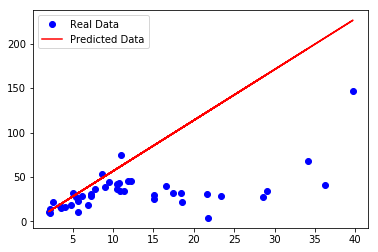

In [43]:
#pLot results
X_np,Y_np = data.T[0],data.T[1]
plt.plot(X_np,Y_np,'bo',label = 'Real Data')
plt.plot(X_np,X_np*w_value+b_value,'r',label='Predicted Data')
plt.legend()
plt.show()